# Using a Modflow model as a stressmodel in Pastas

This notebook shows how to use a simple Modflow model as stress model in Pastas.

## Packages

In [1]:
import os

import flopy
import pandas as pd
import pastas as ps
from pastas.timer import SolveTimer

import pastas_plugins.modflow as ppmf

ps.set_log_level("ERROR")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download MODFLOW executable

In [2]:
bindir = "bin"
mf6_exe = os.path.join(bindir, "mf6")
if not os.path.isfile(mf6_exe):
    if not os.path.isdir(bindir):
        os.makedirs(bindir)
    flopy.utils.get_modflow("bin", repo="modflow6")

## Data

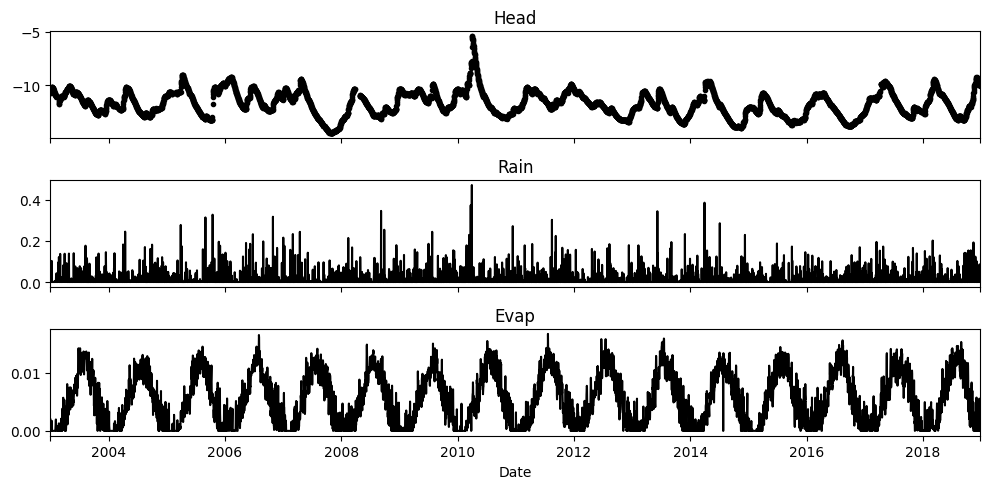

In [3]:
# %%
tmin = pd.Timestamp("2001-01-01")
tmax = pd.Timestamp("2014-12-31")

tmin_wu = tmin - pd.Timedelta(days=3651)
tmin_wu = pd.Timestamp("1986-01-01")

# ds = ps.load_dataset("collenteur_2019")
# head = ds["head"].squeeze()
# prec = ds["rain"].squeeze().resample("D").asfreq().fillna(0.0)
# evap = ds["evap"].squeeze()

head = pd.read_csv("data/obs.csv", index_col=0, parse_dates=True).squeeze()
prec = (
    pd.read_csv("data/rain.csv", index_col=0, parse_dates=True)
    .squeeze()
    .resample("D")
    .asfreq()
    .fillna(0.0)
)
evap = pd.read_csv("data/evap.csv", index_col=0, parse_dates=True).squeeze()

ps.plots.series(head, [prec, evap], hist=False);

## Time series models

### Standard exponential model

Fit report Head                   Fit Statistics
nfev    10                     EVP         87.68
nobs    4291                   R2           0.88
noise   False                  RMSE         0.42
tmin    2003-01-01 00:00:00    AICc     -7500.17
tmax    2014-12-31 00:00:00    BIC      -7474.72
freq    D                      Obj        372.93
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal    initial  vary
test_exp_A  341.874957  29.925748  True
test_exp_a   97.909322  10.000000  True
test_exp_f   -0.878938  -1.000000  True
constant_d  -14.227685 -11.740288  True


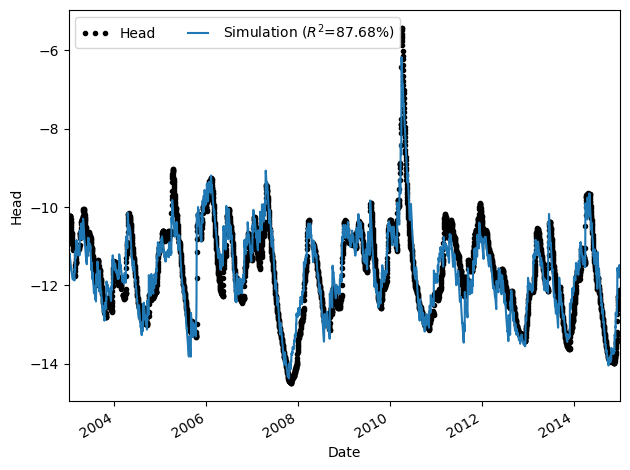

In [4]:
# %%
# create model with exponential response function
mlexp = ps.Model(head)
mlexp.add_stressmodel(
    ps.RechargeModel(prec=prec, evap=evap, rfunc=ps.Exponential(), name="test_exp")
)
mlexp.solve(tmin=tmin, tmax=tmax)
mlexp.plot();

### Uncalibrated MODFLOW time series model

Using parameters based on the Pastas Exponential model.

In [5]:
# %%
# extract resistance and sy from exponential model
# transform exponential parameters to modflow resistance and sy
mlexp_c = mlexp.parameters.loc["test_exp_A", "optimal"]
mlexp_c_i = mlexp.parameters.loc["test_exp_A", "initial"]
mlexp_s = (
    mlexp.parameters.loc["test_exp_a", "optimal"]
    / mlexp.parameters.loc["test_exp_A", "optimal"]
)
mlexp_s_i = (
    mlexp.parameters.loc["test_exp_a", "initial"]
    / mlexp.parameters.loc["test_exp_A", "initial"]
)
mlexp_d = mlexp.parameters.loc["constant_d", "optimal"]
mlexp_d_i = mlexp.parameters.loc["constant_d", "initial"]
mlexp_f = mlexp.parameters.loc["test_exp_f", "optimal"]
mlexp_f_i = mlexp.parameters.loc["test_exp_f", "initial"]

<Axes: xlabel='Date'>

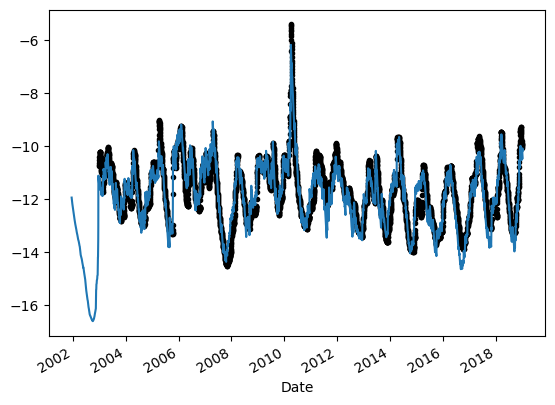

In [6]:
# create modflow pastas model with c and sy
mlexpmf = ps.Model(head)
# shorten the warmup to speed up the modflow calculation somewhat.
mlexpmf.settings["warmup"] = pd.Timedelta(days=4 * 365)
expmf = ppmf.ModflowRch(exe_name=mf6_exe, sim_ws="mf_files/test_expmf", head=head)
expsm = ppmf.ModflowModel(prec=prec, evap=evap, modflow=expmf, name="test_expmfsm")
mlexpmf.add_stressmodel(expsm)
mlexpmf.set_parameter(f"{expsm.name}_s", initial=mlexp_s, vary=False)
mlexpmf.set_parameter(f"{expsm.name}_c", initial=mlexp_c, vary=False)
mlexpmf.set_parameter(f"{expsm.name}_f", initial=mlexp_f, vary=False)
if "constant_d" in mlexpmf.parameters.index:
    mlexpmf.set_parameter("constant_d", initial=mlexp_d, vary=False)
    if expmf._head is not None:
        mlexpmf.del_constant()
        mlexpmf.set_parameter(f"{expsm.name}_d", initial=mlexp_d, vary=False)

sim = mlexpmf.simulate()
ax = mlexpmf.observations().plot(marker=".", color="k", linestyle="None", legend=False)
sim.plot(ax=ax)

In [7]:
mlexpmf.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
test_expmfsm_d,-14.227685,-14.500,-5.420000e+00,False,test_expmfsm,uniform,NaN,NaN
test_expmfsm_c,341.874957,10.000,1.000000e+08,False,test_expmfsm,uniform,NaN,NaN
test_expmfsm_s,0.286389,0.001,5.000000e-01,False,test_expmfsm,uniform,NaN,NaN
test_expmfsm_f,-0.878938,-2.000,0.000000e+00,False,test_expmfsm,uniform,NaN,NaN


## Calibrated MODFLOW time series model

Now fit a Pastas Model using the Modflow model as a response function. This takes some
time, as the modflow model has to be recomputed for every iteration in the optimization
process.

In [8]:
ml = ps.Model(head)
ml.del_constant()
# shorten the warmup to speed up the modflow calculation somewhat.
ml.settings["warmup"] = pd.Timedelta(days=4 * 365)
mf = ppmf.ModflowRch(exe_name=mf6_exe, sim_ws="mf_files/test_mfrch", head=head)
sm = ppmf.ModflowModel(prec, evap, modflow=mf, name="test_mfsm")
ml.add_stressmodel(sm)

ml.set_parameter(f"{sm.name}_s", initial=mlexp_s_i, vary=True)
ml.set_parameter(f"{sm.name}_c", initial=mlexp_c_i, vary=True)
ml.set_parameter(f"{sm.name}_f", initial=mlexp_f_i, vary=True)
# ml.set_parameter("constant_d", initial=mlexp_d_i, vary=True)

with SolveTimer() as st:
    ml.solve(callback=st.timer)

Optimization progress: 53it [02:19,  2.63s/it]

Fit report Head                   Fit Statistics
nfev    17                     EVP         86.85
nobs    5737                   R2           0.87
noise   False                  RMSE         0.43
tmin    2003-01-01 00:00:00    AICc     -9760.95
tmax    2018-12-25 00:00:00    BIC      -9734.34
freq    D                      Obj        522.56
warmup  1460 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
                optimal    initial  vary
test_mfsm_d  -13.843900 -11.740288  True
test_mfsm_c  319.022453  29.925748  True
test_mfsm_s    0.315744   0.334160  True
test_mfsm_f   -0.980087  -1.000000  True

Warnings! (1)
Response tmax for 'test_mfsm' > than calibration period.


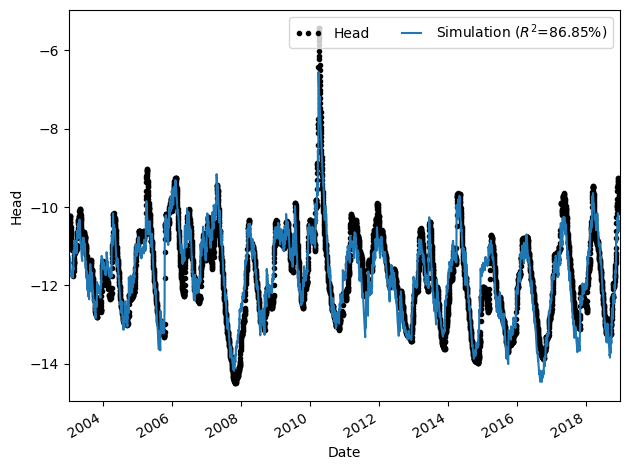

In [9]:
ml.plot();

## Results

### Parameters

In [10]:
ml.parameters.style.set_table_attributes('style="font-size: 12px"').set_caption(
    "Pastas-Modflow"
)

,initial,pmin,pmax,vary,name,dist,stderr,optimal
test_mfsm_d,-11.740288,-14.500000,-5.420000,True,test_mfsm,uniform,0.023597,-13.843900
test_mfsm_c,29.925748,10.000000,100000000.000000,True,test_mfsm,uniform,2.552015,319.022453
test_mfsm_s,0.334160,0.001000,0.500000,True,test_mfsm,uniform,0.003336,0.315744
test_mfsm_f,-1.000000,-2.000000,0.000000,True,test_mfsm,uniform,0.004257,-0.980087


In [11]:
mlexp.parameters.style.set_table_attributes('style="font-size: 12px"').set_caption(
    "Pastas-Exponential"
)

,initial,pmin,pmax,vary,name,dist,stderr,optimal
test_exp_A,29.925748,0.000010,2992.574763,True,test_exp,uniform,2.845206,341.874957
test_exp_a,10.000000,0.010000,1000.000000,True,test_exp,uniform,0.895851,97.909322
test_exp_f,-1.000000,-2.000000,0.000000,True,test_exp,uniform,0.010571,-0.878938
constant_d,-11.740288,nan,nan,True,constant,uniform,0.034303,-14.227685


Compare parameters from the Pastas-Modflow model to the "true" parameters derived from
the Pastas exponential model.

In [12]:
comparison = pd.DataFrame(
    {
        "True": mlexpmf.parameters["initial"].values,
        "MF6": ml.parameters["optimal"].values,
    },
    index=ml.parameters.index,
)
comparison["Difference"] = comparison["MF6"] - comparison["True"]
comparison["% Difference"] = (comparison["Difference"] / comparison["True"]) * 100
comparison.style.format(precision=2)

,True,MF6,Difference,% Difference
test_mfsm_d,-14.23,-13.84,0.38,-2.70
test_mfsm_c,341.87,319.02,-22.85,-6.68
test_mfsm_s,0.29,0.32,0.03,10.25
test_mfsm_f,-0.88,-0.98,-0.10,11.51


### Plots

Compare the Pastas-Modflow simulation to the Pastas-Exponential simulation.

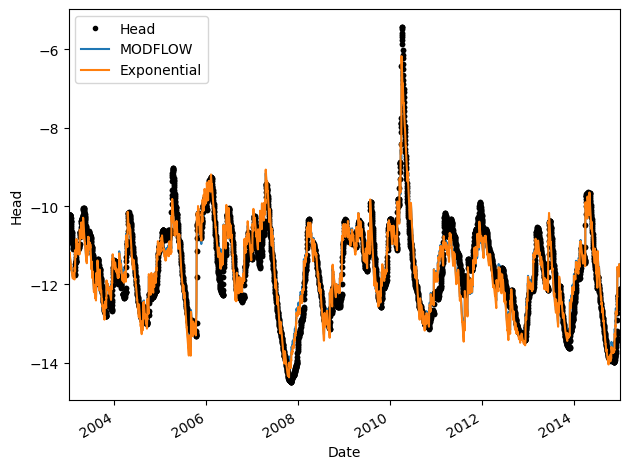

In [13]:
ax = ml.plot()  # Pastas-Modflow
mlexp.plot(ax=ax)  # Pastas-Exponential
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[0:2] + handles[3:],
    labels[0:1] + ["MODFLOW", "Exponential"],
    loc="upper left",
)